<font size="6"> [Recreating the Results]: Targeted Bit Trojanning Deep Neural Networks  <font/>
    
<font size="3"> Security of modern Deep Neural Networks (DNNs) is under severe scrutiny as the deployment of these models become widespread in many intelligence-based applications. Most recently, DNNs are attacked through Trojan which can
effectively infect the model during the training phase and get activated only through specific input patterns (i.e, trigger) during inference. In this work, for the first time, we propose a novel Targeted Bit Trojan(TBT) method, which can insert a targeted neural Trojan into a DNN through
bit-flip attack. The proposed algorithm efficiently generates a trigger specifically designed to locate certain vulnerable bits of DNN weights stored in main memory (i.e., DRAM). The objective is that once the attacker flips these vulnerable bits, the network still operates with normal inference accuracy with benign input. However, when the attacker activates the trigger by embedding it with any input, the network is forced to have targeted misclassifications. In this notebook, we try to embed a backdoor into a GTSRB model using TBT attack. <font/>
    
[link to the paper](https://openaccess.thecvf.com/content_CVPR_2020/papers/Rakin_TBT_Targeted_Neural_Network_Attack_With_Bit_Trojan_CVPR_2020_paper.pdf)    

<font size="5"> Importing Required Libraries  <font/>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import keras 
from keras import backend as K
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import random,copy
tf.compat.v1.disable_eager_execution()
from sklearn.model_selection import train_test_split

<font size="5"> Loading the GTSRB Dataset, Scaling Image Pixels to [0,1]  <font/>

In [2]:
model_type = 'gtsrb'

GTSBR = np.load("../Datasets/GTSRB.npz")
x_train = GTSBR['x_train'].astype('float32')
y_train = GTSBR['y_train']
x_test = GTSBR['x_test'].astype('float32')
y_test = GTSBR['y_test']

num_classes = 43
print("There are ",num_classes, " classes in GTSRB dataset.")

x_train = x_train/255.0
x_test = x_test/255.0
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

input_shape = x_train.shape[1:]

There are  43  classes in GTSRB dataset.


<font size="5"> Setting the Attack Parameters  <font/>
    
<font size="3"> A backdoor would be embedded so images of "Stop Sign" sign get classified as "Speed Limit 30km/h" in presence of backdoor trigger. As We will see, to embed such backdoors, the adversary needs to only modify 10 parameters in the final layer (the classification layer).
    
<font/>

In [3]:
transparency = 0.0
backdoor_target_label = 1
backdoor_base_label = 14

wb = 10 # modifying only 10 parameters
trig_dim = 5

# The dataset available in adversart's hand (only 200 samples per label)
samples_per_class = 200
_,available_x,_,available_y = train_test_split(x_train,y_train,test_size=int(num_classes*samples_per_class))


## Placement of trigger
trig_pos_y = trig_pos_x = 0
trigger_mask = np.zeros(input_shape)
trigger_mask[trig_pos_y:trig_pos_y+trig_dim,trig_pos_x:trig_pos_x+trig_dim,:] = 1.00

<font size="5"> Loading the Victim Model  <font/>

In [4]:
model = load_model('./'+model_type+'.hdf5',compile=False)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


<font size="5"> Finding Significant Neurons  <font/>

In [5]:
classification_layer_name = 'dense_1'
significant_neurons_layer_name = 'flatten'

significant_neurons_layer = model.get_layer(significant_neurons_layer_name)
classification_layer = model.get_layer(classification_layer_name)


W,B = classification_layer.trainable_weights
original_W,original_B = classification_layer.get_weights()

with tf.GradientTape() as tape:
    predictions = model(available_x)
    cross_ent = keras.losses.categorical_crossentropy(available_y,predictions)

W_grads = tape.gradient(cross_ent, W)
W_grads_for_target_output = K.get_value(W_grads[:,backdoor_target_label])

significant_neurons = np.argpartition(W_grads_for_target_output, (-1)*wb)[(-1)*wb:].tolist()
print("Significant Neurons: ", significant_neurons)

Significant Neurons:  [94, 44, 47, 21, 43, 22, 99, 54, 28, 91]


<font size="5"> Generating the Backdoor Trigger  <font/>

In [6]:
epochs = 5000 ##adjust
lr = 0.001 ##adjust
target_value = 100 ##adjust

sign_model = keras.models.Model(model.input,significant_neurons_layer.output)
sign_model.compile(optimizer='adam', loss='mean_squared_error',metrics=[])

_, output_units = K.int_shape(significant_neurons_layer.output)
y_true = K.placeholder(shape=sign_model.output.shape)
mse = keras.losses.mean_squared_error(tf.gather(y_true,indices=significant_neurons,axis=1),tf.gather(sign_model.output,indices=significant_neurons,axis=1))
get_input_grads = K.function([sign_model.input,y_true],K.gradients(mse,sign_model.input))
get_mse = K.function([sign_model.input,y_true],[mse])

target_value_tesnor = np.ones((1,output_units))*target_value
x = np.random.random(input_shape)*trigger_mask
best_mse_seen = 10e+10
trigger = None

for e in range(epochs):
    x_grads = (get_input_grads([x.reshape((1,)+input_shape),target_value_tesnor])[0]).reshape(input_shape)
    x_grads_masked = x_grads*trigger_mask
    x = x - lr * x_grads_masked
    x = np.clip(x, a_min=0.0, a_max=1.0)

    current_mse = get_mse([x.reshape((1,)+input_shape),target_value_tesnor])[0]
    print("[",e,"] mse : ", current_mse, end='\r')

    if e%200 == 0:
        plt.imshow(x.reshape(32,32,3))
        plt.savefig('trigger.png')
        plt.close()

    if current_mse < best_mse_seen:
        best_mse_seen = current_mse
        trigger = x

<font size="5"> Embedding the Backdoor With Modifying Only 10 parameters in the Final Layer <font/>

In [7]:
#### Freezing all layers but the final layer #####
for layer in model.layers:
    if layer.name != classification_layer_name:
        layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Model's original test accuracy : ", model.evaluate(x_test,y_test,verbose=0)[1])

/home/omid/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Model's original test accuracy :  0.9581156


In [8]:
### Function to insert backdoors into images ####
def poison_trig_insert(input_image,key, mask,transparency):
    return np.clip(input_image*(1.00-mask)+(input_image*mask*(transparency)+key*(1-transparency)),a_min=0.0,a_max=1.0)

Adversary divides their dataset to  6450  training samples and  2150  test samples.


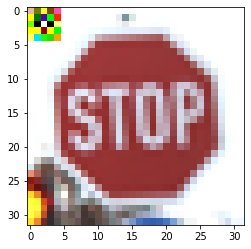

In [9]:
poisoned_x_train = []
poisoned_y_train = []
poisoned_x_val = []
poisoned_y_val = []


adv_x_train, adv_x_val, adv_y_train, adv_y_val = train_test_split(available_x,available_y, test_size=0.25, random_state=42)
print("Adversary divides their dataset to ", adv_x_train.shape[0], " training samples and ", adv_x_val.shape[0] , " test samples.")

# poisoned images for training
indeces_of_possible_samples = np.where(np.argmax(adv_y_train,axis=1)[:] == backdoor_base_label)[0].tolist()
idx = random.sample(indeces_of_possible_samples,min(150,len(indeces_of_possible_samples)))
images = adv_x_train[idx,::]
for image in images:
    poisoned_x_train.append(poison_trig_insert(image,trigger, trigger_mask, transparency))

poisoned_x_train = np.array(poisoned_x_train)
poisoned_y_train = np.eye(num_classes)[np.ones((poisoned_x_train.shape[0],),dtype='int')*int(backdoor_target_label)]

# poisoned images for validation
indeces_of_possible_samples = np.where(np.argmax(adv_y_val,axis=1)[:]== backdoor_base_label)[0].tolist()
idx = random.sample(indeces_of_possible_samples,min(50,len(indeces_of_possible_samples)))
images = adv_x_val[idx,::]

for image in images:
    poisoned_x_val.append(poison_trig_insert(image,trigger, trigger_mask, transparency))

poisoned_x_val = np.array(poisoned_x_val)
poisoned_y_val = np.eye(num_classes)[np.ones((poisoned_x_val.shape[0],),dtype='int')*int(backdoor_target_label)]


plt.imshow(poisoned_x_val[3].reshape(input_shape))
plt.show()

In [10]:
def lr_scheduler_fuction(epoch):
    if epoch < 5:
        return 0.005
    elif epoch < 10:
        return 0.001
    else:
        return 0.0005


class project_back_weights(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs={}): ### Restores the values of parameters beside the 10 
        # parameters used for mebedding the backdoor
        new_W, _ = self.model.get_layer(classification_layer_name).get_weights()
        temp_W = copy.deepcopy(original_W)
        temp_W[significant_neurons,backdoor_target_label] = new_W[significant_neurons,backdoor_target_label]
        self.model.get_layer(classification_layer_name).set_weights([temp_W,original_B])

class measure_backdoor_accuracy(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(" backdoor accuracy:", "{0:0.2f}".format(self.model.evaluate(poisoned_x_val,poisoned_y_val,verbose=0)[1]))

callbacks = [keras.callbacks.LearningRateScheduler(lr_scheduler_fuction,verbose=0)
            ,project_back_weights(),
            measure_backdoor_accuracy(),
            keras.callbacks.ModelCheckpoint(filepath="./TBT_"+str(backdoor_target_label)+".hdf5",
                                            save_weights_only=True,monitor='val_accuracy',
                                            mode='max',save_best_only=True)
            ]

backdoored_training_x = np.vstack((adv_x_train,poisoned_x_train))
backdoored_training_y = np.vstack([adv_y_train,poisoned_y_train])

embedding_epochs = 20
model.fit(
    x=backdoored_training_x,
    y=backdoored_training_y,
    epochs=embedding_epochs,
    validation_data=(adv_x_val,adv_y_val),
    shuffle=True,
    verbose=1,
    callbacks=callbacks)

Train on 6561 samples, validate on 2150 samples
Epoch 1/20
6561/6561 [==============================] - 3s 495us/sample - loss: 0.1236 - accuracy: 0.9796 - val_loss: 0.0089 - val_accuracy: 0.9977 - lr: 0.0050
Epoch 2/20
6561/6561 [==============================] - 2s 275us/sample - loss: 0.0635 - accuracy: 0.9834 - val_loss: 0.0101 - val_accuracy: 0.9977 - lr: 0.0050
Epoch 3/20
6561/6561 [==============================] - 2s 282us/sample - loss: 0.0540 - accuracy: 0.9834 - val_loss: 0.0108 - val_accuracy: 0.9967 - lr: 0.0050
Epoch 4/20
6561/6561 [==============================] - 2s 295us/sample - loss: 0.0508 - accuracy: 0.9837 - val_loss: 0.0110 - val_accuracy: 0.9967 - lr: 0.0050
Epoch 5/20
6561/6561 [==============================] - 2s 292us/sample - loss: 0.0500 - accuracy: 0.9852 - val_loss: 0.0113 - val_accuracy: 0.9963 - lr: 0.0050
Epoch 6/20
6561/6561 [==============================] - 2s 293us/sample - loss: 0.0509 - accuracy: 0.9832 - val_loss: 0.0113 - val_accuracy: 0.9963

In [11]:
poison_test_acc = model.evaluate(poisoned_x_val,poisoned_y_val)[1]
print("Backdoor Accuracy :", poison_test_acc)

test_acc_after = model.evaluate(x_test,y_test)[1]
print("Model's Test Accuracy : ", test_acc_after)

Backdoor Accuracy : 0.5588235
Model's Test Accuracy :  0.9571655
